## Performing imports

In [1]:
import csv
import re
import nltk
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import random
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

from pandas import ExcelWriter
from pandas import ExcelFile
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, cross_val_score

#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('punkt')

%matplotlib inline

## Loading the dataset

In [2]:
train = pd.read_excel('train_main.xlsx',sheet_name=0)
train.to_csv('train_csv',index = False ,encoding = 'utf-8')

In [3]:
test = pd.read_excel('test_main.xlsx',sheet_name=0)
test.to_csv('test_csv',index = False ,encoding = 'utf-8')

In [4]:
df_train = pd.read_csv('train_csv')
df_test = pd.read_csv('test_csv')

In [5]:
df_train.head()

,ItemID,Sentiment,SentimentText
0,0,0,...
1,1,0,is so sad for my APL frie...
2,2,0,I missed the New Moon trail...
3,3,1,omg its already 7:30 :O
4,4,0,.. Omgaga. Im sooo im gunna CRy. I'...


In [6]:
df_test.head()

,ItemID,SentimentText
0,100001,@cupcake_kitty I love how you're so live on tw...
1,100002,@cupcake_nyc boooo hahah ugh this weekend is ...
2,100003,@cupcake_nyc sounds good I have some things to...
3,100004,@cupcake_nyc Why does Yahoo! always only take ...
4,100005,"@cupcake_rachel ha ha, you do amuse me Rach x"


# Data Cleaning

## Finding and removing None values

In [7]:
len(df_train)

99990

In [8]:
df_train.isnull().sum()

ItemID             0
Sentiment          0
SentimentText    128
dtype: int64

In [9]:
df_train.dropna(inplace = True)

len(df_train)

99862

In [10]:
len(df_test)

200000

In [11]:
df_test.isnull().sum()

ItemID            0
SentimentText    42
dtype: int64

In [12]:
df_test.dropna(inplace = True)

len(df_test)

199958

## Finding and removing empty strings 

In [13]:
blanks = []

for i,it,s,st in df_train.itertuples():
    if type(st)==str:
        if st.isspace():
            blanks.append(i)
            
print(len(blanks), 'blanks :' ,blanks)

2 blanks : [0, 11]


In [14]:
df_train.drop(blanks, inplace=True)

len(df_train)

99860

In [15]:
blanks = []

for i,it,st in df_test.itertuples():
    if type(st)==str:
        if st.isspace():
            blanks.append(i)
            
print(len(blanks), 'blanks :' ,blanks)

0 blanks : []


## Removing twitter handler(@)

In [46]:
combi = df_train.append(df_test, ignore_index=True,sort=False)
len(combi)

299818

In [17]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

In [18]:
df_train['SentimentText'] = np.vectorize(remove_pattern)(df_train['SentimentText'].apply(str), "@[\w]*") 
df_train.head()

,ItemID,Sentiment,SentimentText
1,1,0,is so sad for my APL frie...
2,2,0,I missed the New Moon trail...
3,3,1,omg its already 7:30 :O
4,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
5,5,0,i think mi bf is cheating on me!!! ...


In [19]:
df_test['SentimentText'] = np.vectorize(remove_pattern)(df_test['SentimentText'].apply(str), "@[\w]*") 
df_test.head()

,ItemID,SentimentText
0,100001,I love how you're so live on twitter now .. W...
1,100002,boooo hahah ugh this weekend is jam packed n...
2,100003,sounds good I have some things to chat with y...
3,100004,Why does Yahoo! always only take US sales int...
4,100005,"ha ha, you do amuse me Rach x"


## Removing numbers and special characters

In [20]:
df_train['SentimentText'] = df_train['SentimentText'].str.replace("[^a-zA-Z#]", " ")
df_train.head()

,ItemID,Sentiment,SentimentText
1,1,0,is so sad for my APL frie...
2,2,0,I missed the New Moon trail...
3,3,1,omg its already O
4,4,0,Omgaga Im sooo im gunna CRy I ...
5,5,0,i think mi bf is cheating on me ...


In [21]:
df_test['SentimentText'] = df_test['SentimentText'].str.replace("[^a-zA-Z#]", " ")
df_test.head()

,ItemID,SentimentText
0,100001,I love how you re so live on twitter now W...
1,100002,boooo hahah ugh this weekend is jam packed n...
2,100003,sounds good I have some things to chat with y...
3,100004,Why does Yahoo always only take US sales int...
4,100005,ha ha you do amuse me Rach x


## Removing stop words 

In [22]:
stop = stopwords.words("english")

df_train['SentimentText'] = df_train['SentimentText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_train.head()

,ItemID,Sentiment,SentimentText
1,1,0,sad APL friend
2,2,0,I missed New Moon trailer
3,3,1,omg already O
4,4,0,Omgaga Im sooo im gunna CRy I dentist since I ...
5,5,0,think mi bf cheating T T


In [23]:
df_test['SentimentText'] = df_test['SentimentText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_test.head()

,ItemID,SentimentText
0,100001,I love live twitter When st came used tweet li...
1,100002,boooo hahah ugh weekend jam packed nj fun conc...
2,100003,sounds good I things chat I know bad weekend I...
3,100004,Why Yahoo always take US sales account
4,100005,ha ha amuse Rach x


## Replacing abbreviations

In [24]:
def translator(user_string):
    user_string = user_string.split(' ')
    j = 0
    
    for i in user_string:
        
        fileName = "abbr.txt"
        with open(fileName, "r") as abbrfile:
            dataFromFile = csv.reader(abbrfile, delimiter="=")
            for row in dataFromFile:
                
                if i.upper() == row[0]:
                    user_string[j] = row[1]
            abbrfile.close()
        j = j + 1
    return ' '.join(user_string)

In [25]:
df_train['SentimentText'] = df_train['SentimentText'].apply(lambda x:  translator(x)  ) 
df_train.head()

,ItemID,Sentiment,SentimentText
1,1,0,sad APL friend
2,2,0,I missed New Moon trailer
3,3,1,oh my god already O
4,4,0,Omgaga Im sooo im gunna CRy I dentist since I ...
5,5,0,think mi bf cheating T T


In [26]:
df_test['SentimentText'] = df_test['SentimentText'].apply(lambda x:  translator(x)  ) 
df_test.head()

,ItemID,SentimentText
0,100001,I love live twitter When st came used tweet li...
1,100002,boooo hahah ugh weekend jam packed nj fun conc...
2,100003,sounds good I things chat I know bad weekend I...
3,100004,Why Yahoo always take US sales account
4,100005,ha ha amuse Rach x


## Tokenization 

In [27]:
df_train['SentimentText'] = df_train['SentimentText'].apply(lambda x: word_tokenize(x))
df_train.head()

,ItemID,Sentiment,SentimentText
1,1,0,"[sad, APL, friend]"
2,2,0,"[I, missed, New, Moon, trailer]"
3,3,1,"[oh, my, god, already, O]"
4,4,0,"[Omgaga, Im, sooo, im, gunna, CRy, I, dentist,..."
5,5,0,"[think, mi, bf, cheating, T, T]"


In [28]:
df_test['SentimentText'] = df_test['SentimentText'].apply(lambda x: word_tokenize(x))
df_test.head()

,ItemID,SentimentText
0,100001,"[I, love, live, twitter, When, st, came, used,..."
1,100002,"[boooo, hahah, ugh, weekend, jam, packed, nj, ..."
2,100003,"[sounds, good, I, things, chat, I, know, bad, ..."
3,100004,"[Why, Yahoo, always, take, US, sales, account]"
4,100005,"[ha, ha, amuse, Rach, x]"


## Stemming 

In [29]:
ps = PorterStemmer()

df_train['SentimentText2'] = df_train['SentimentText'].apply(lambda x: ' '.join([ps.stem(word) for word in x]))
df_train.head()

,ItemID,Sentiment,SentimentText,SentimentText2
1,1,0,"[sad, APL, friend]",sad apl friend
2,2,0,"[I, missed, New, Moon, trailer]",I miss new moon trailer
3,3,1,"[oh, my, god, already, O]",oh my god alreadi O
4,4,0,"[Omgaga, Im, sooo, im, gunna, CRy, I, dentist,...",omgaga Im sooo im gunna cri I dentist sinc I s...
5,5,0,"[think, mi, bf, cheating, T, T]",think mi bf cheat T T


In [30]:
df_test['SentimentText2'] = df_test['SentimentText'].apply(lambda x: ' '.join([ps.stem(word) for word in x]))
df_test.head()

,ItemID,SentimentText,SentimentText2
0,100001,"[I, love, live, twitter, When, st, came, used,...",I love live twitter when st came use tweet lik...
1,100002,"[boooo, hahah, ugh, weekend, jam, packed, nj, ...",boooo hahah ugh weekend jam pack nj fun concer...
2,100003,"[sounds, good, I, things, chat, I, know, bad, ...",sound good I thing chat I know bad weekend I s...
3,100004,"[Why, Yahoo, always, take, US, sales, account]",whi yahoo alway take US sale account
4,100005,"[ha, ha, amuse, Rach, x]",ha ha amus rach x


## Lemmatization

In [31]:
lmtzr = WordNetLemmatizer()

df_train['SentimentText'] = df_train['SentimentText'].apply(lambda x: ' '.join([lmtzr.lemmatize(word,'v') for word in x]))
df_train.head()

,ItemID,Sentiment,SentimentText,SentimentText2
1,1,0,sad APL friend,sad apl friend
2,2,0,I miss New Moon trailer,I miss new moon trailer
3,3,1,oh my god already O,oh my god alreadi O
4,4,0,Omgaga Im sooo im gunna CRy I dentist since I ...,omgaga Im sooo im gunna cri I dentist sinc I s...
5,5,0,think mi bf cheat T T,think mi bf cheat T T


In [32]:
df_test['SentimentText'] = df_test['SentimentText'].apply(lambda x: ' '.join([lmtzr.lemmatize(word,'v') for word in x]))
df_test.head()

,ItemID,SentimentText,SentimentText2
0,100001,I love live twitter When st come use tweet lik...,I love live twitter when st came use tweet lik...
1,100002,boooo hahah ugh weekend jam pack nj fun concer...,boooo hahah ugh weekend jam pack nj fun concer...
2,100003,sound good I things chat I know bad weekend I ...,sound good I thing chat I know bad weekend I s...
3,100004,Why Yahoo always take US sales account,whi yahoo alway take US sale account
4,100005,ha ha amuse Rach x,ha ha amus rach x


## Word Cloud for common words

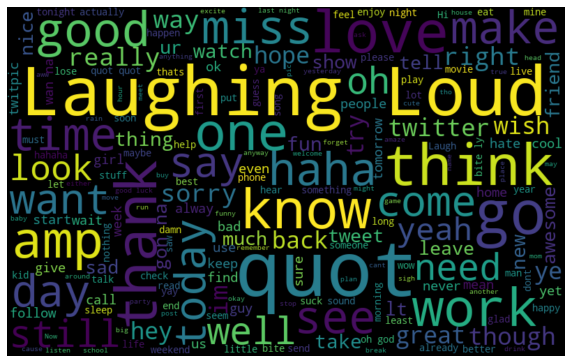

In [33]:
all_words = ' '.join([text for text in df_train['SentimentText']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Word Cloud for positive words 

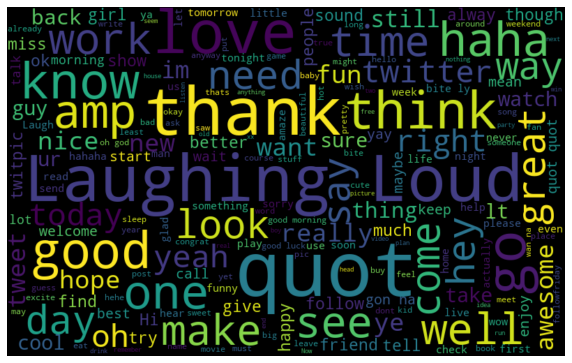

In [34]:
positive_words =' '.join([text for text in df_train['SentimentText'][df_train['Sentiment'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Word Cloud for negative words 

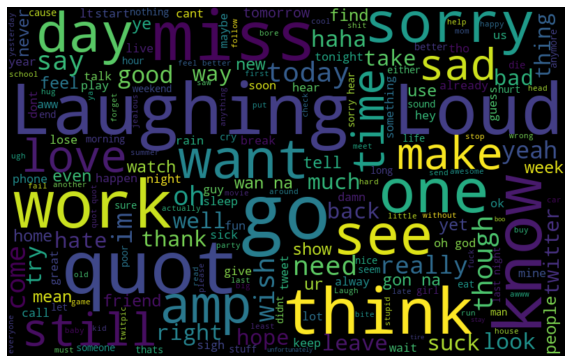

In [35]:
negative_words =' '.join([text for text in df_train['SentimentText'][df_train['Sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Feature Extraction

## Bag of words features 

In [36]:
bow_vectorizer = CountVectorizer()

bow = bow_vectorizer.fit_transform(df_train['SentimentText'])
bow.shape

(99860, 48676)

## TF-IDF features 

In [37]:
tfidf_vectorizer = TfidfVectorizer()

tfidf = tfidf_vectorizer.fit_transform(df_train['SentimentText'])
tfidf.shape

(99860, 48676)

# Model Building

## Naive Bayes Model 

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df_train['SentimentText'], df_train['Sentiment'], random_state=42, test_size=0.33)

# create pipeline
pipeline_nb = Pipeline([('tfidf', TfidfVectorizer()), ('classifier', MultinomialNB())])

pipeline_nb.fit(X_train, y_train)
predictions = pipeline_nb.predict(X_test)

print(metrics.confusion_matrix(y_test,predictions))
print(metrics.classification_report(y_test,predictions))
print(metrics.accuracy_score(y_test,predictions))

[[ 7955  6387]
 [ 2495 16117]]
              precision    recall  f1-score   support

           0       0.76      0.55      0.64     14342
           1       0.72      0.87      0.78     18612

    accuracy                           0.73     32954
   macro avg       0.74      0.71      0.71     32954
weighted avg       0.74      0.73      0.72     32954

0.7304727802391212


## SVM Model

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df_train['SentimentText'], df_train['Sentiment'], random_state=42, test_size=0.33)

# create pipeline
pipeline_svm = Pipeline([('tfidf', TfidfVectorizer()), ('classifier', LinearSVC())])

pipeline_svm.fit(X_train, y_train)
predictions = pipeline_svm.predict(X_test)

print(metrics.confusion_matrix(y_test,predictions))
print(metrics.classification_report(y_test,predictions))
print(metrics.accuracy_score(y_test,predictions))

[[ 9445  4897]
 [ 3842 14770]]
              precision    recall  f1-score   support

           0       0.71      0.66      0.68     14342
           1       0.75      0.79      0.77     18612

    accuracy                           0.73     32954
   macro avg       0.73      0.73      0.73     32954
weighted avg       0.73      0.73      0.73     32954

0.7348121624082053


## Random Forest Model

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df_train['SentimentText'], df_train['Sentiment'], random_state=42, test_size=0.33)

# create pipeline
pipeline_rf = Pipeline([('tfidf', TfidfVectorizer()), ('classifier', RandomForestClassifier())])

pipeline_rf.fit(X_train, y_train)
predictions = pipeline_nb.predict(X_test)

print(metrics.confusion_matrix(y_test,predictions))
print(metrics.classification_report(y_test,predictions))
print(metrics.accuracy_score(y_test,predictions))

C:\Users\vardh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[ 7955  6387]
 [ 2495 16117]]
              precision    recall  f1-score   support

           0       0.76      0.55      0.64     14342
           1       0.72      0.87      0.78     18612

    accuracy                           0.73     32954
   macro avg       0.74      0.71      0.71     32954
weighted avg       0.74      0.73      0.72     32954

0.7304727802391212


## Predicting data

In [43]:
new_preds = pipeline_svm.predict(df_test['SentimentText'])

df_new_preds = df_test.copy()
df_new_preds['predictions'] = new_preds
df_new_preds.shape

(199958, 4)

In [44]:
index = random.sample(range(new_preds.shape[0]), 20)
for SentimentText, Sentiment in zip(df_new_preds.SentimentText[index], df_new_preds.predictions[index]):
    print (Sentiment, '--', SentimentText, '\n')

1 -- welcome yyour lookkk UNTRACEABLE yyour Soo Unique I never see Bring imma go buy 

0 -- Mine run today 

0 -- ahhh noperss miss last show actually hear people say cry 

1 -- hey baby great hit well love song 

0 -- I NEED FACE TIME Third concert come STILL nothin Can afford VIP give hint How I meet ya 

0 -- I take upload Dad big sis still pre ball take 

0 -- I like amaze job sooo dark You really good job get everything tho get wrong 

1 -- You first person say Everyone thank god make 

1 -- well I glad I could first reply Have good weekend man 

0 -- I suppose avoid That frustrate 

1 -- CONGRATS successful jump perfectly good aircraft You way earn WINGS Yahooooooo 

1 -- hic em mu n test th xem n l c g th v c n b n l nhi You ng tr c b kh ng c nh b 

1 -- Lots lot Vitamin D week 

0 -- I well couple hours ago 

1 -- new song bomb love 

0 -- suppose open 

1 -- toking equation happy 

0 -- aww thank yeah sis middle school phase clash mom impatience Things better I think 

1 -- ok